In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})

## Exercise 1

In [2]:
A = np.array(
    [[0, 0, 1],
     [1, 1, 1],
     [4, 2, 1]]
)

b = np.array([6, 0, 0])

# method #1:
Ai = np.linalg.inv(A)
solution1 = Ai.dot(b)
print(solution1)

# method #2:
solution2 = np.linalg.solve(A,b)
print(solution2)

[ 3. -9.  6.]
[ 3. -9.  6.]


## Exercise 2

In [3]:
m, b = 0.1, 1.8

N = 1000000
x = np.linspace(0, 100, N)
y = m * x + b + 0.1 * np.random.randn(N)

In [4]:
%%time

# compute error without numpy:
err_list = 0
for i in range(N):
    err_list+=(y[i] - m*x[i] - b)**2/N
print(err_list)

0.009988213274873039
CPU times: user 509 ms, sys: 0 ns, total: 509 ms
Wall time: 508 ms


In [5]:
%%time

# compute error with numpy:
err = np.sum((y - m*x - b)**2/N)
print(err)

0.009988213274873033
CPU times: user 2.37 ms, sys: 3.96 ms, total: 6.33 ms
Wall time: 43.3 ms


## Exercise 3

In [6]:
def trapz_fixed_int(f,x):
    '''
        uses the trapezoidal rule to integrate a function f
        sampled at points x
    '''
    return np.sum(0.5 * (x[1:] - x[:-1]) * (f[1:] + f[:-1]))

xx = np.linspace(0,5,1048577) # the largest number of grid-points used in trapz_int before
ans = 5.**3 / 3 + 3 * 5.

In [7]:
%%time 
tst= trapz_fixed_int(xx**2 + 3,xx)
print(tst)
print(f'error of {(ans - tst)/ans*100:.4e}% ')

56.666666666685714
error of -3.3617e-11% 
CPU times: user 7.17 ms, sys: 0 ns, total: 7.17 ms
Wall time: 6.51 ms


## Exercise 4 

In [8]:
def fundiff2(ff,xx):
    '''
        computes the second-order finite differences approximation to the second derivative 
        of a function f with values sampled at a grid-points xx, assuming that the grid-points
        in xx are evenly spaced
    '''
    # compute array of grid-spacing h, and check that xx are all evenly spaced:
    hh = xx[1] - xx[0]
    if np.any(abs(np.diff(xx) - hh)>1e-14):
        raise ValueError('expected evenly spaced grid')
    
    # initialize array to hold derivative values:
    df2 = np.zeros_like(ff)
    
    # use centred differences to compute second derivatives at interior points:
    df2[1:-1] = (ff[2:] - 2*ff[1:-1] + ff[:-2])/hh/hh
    
    # apply forward/backward formulae at endpoints:
    df2[0] = (ff[2] - 2*ff[1] + ff[0]) /hh/hh
    df2[-1]= (ff[-1]- 2*ff[-2]+ ff[-3])/hh/hh
    return df2

In [9]:
xx = np.linspace(0,1,100)
ff = np.cos(20*xx)*np.exp(-2*xx)
dfdx2 = np.exp(-2*xx)*(-396*np.cos(20*xx) + 80*np.sin(20*xx))

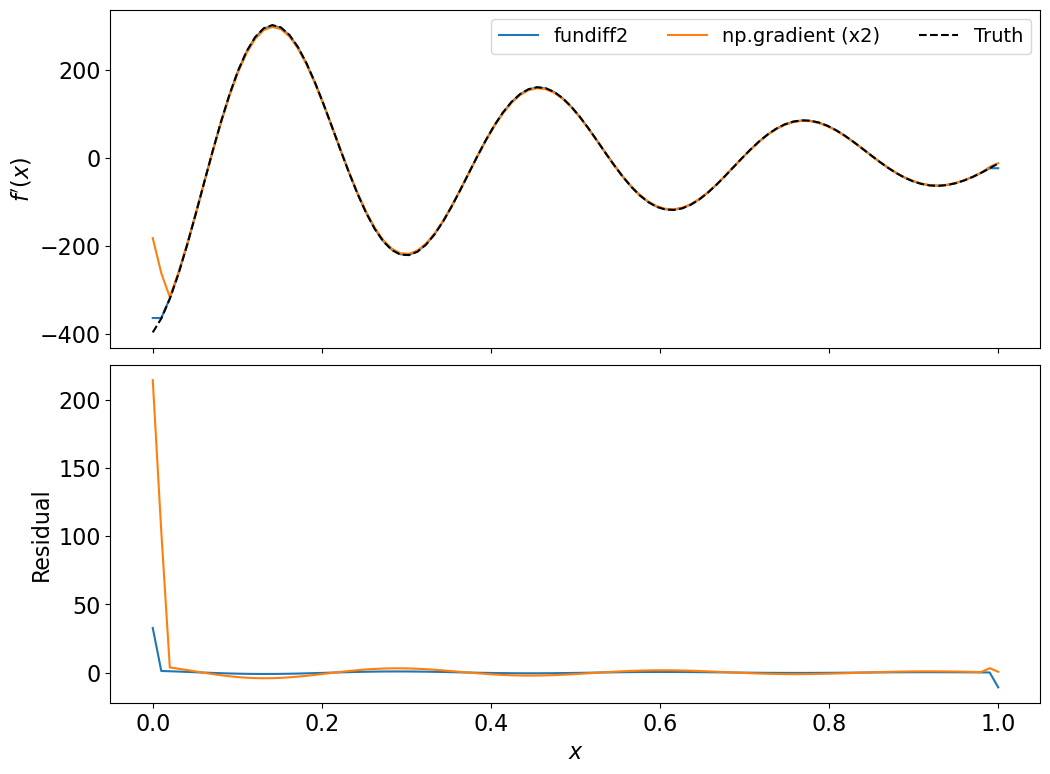

In [10]:
f,ax = plt.subplots(2,1,figsize=(12,9),sharex=True)
ax[0].plot(xx,fundiff2(ff,xx),label='fundiff2')
ax[0].plot(xx,np.gradient(np.gradient(ff,xx),xx),label='np.gradient (x2)')
ax[0].plot(xx,dfdx2,'k--',label='Truth')
ax[1].plot(xx,fundiff2(ff,xx)-dfdx2)
ax[1].plot(xx,np.gradient(np.gradient(ff,xx),xx)-dfdx2)
ax[1].set_xlabel('$x$')
ax[0].set_ylabel("$f'(x)$")
ax[1].set_ylabel('Residual')
ax[0].legend(ncol=3,fontsize=14)
plt.subplots_adjust(hspace=0.05)

## Exercise 5


root found at 3.000000071525574
root found at 4.0
root found at 5.0


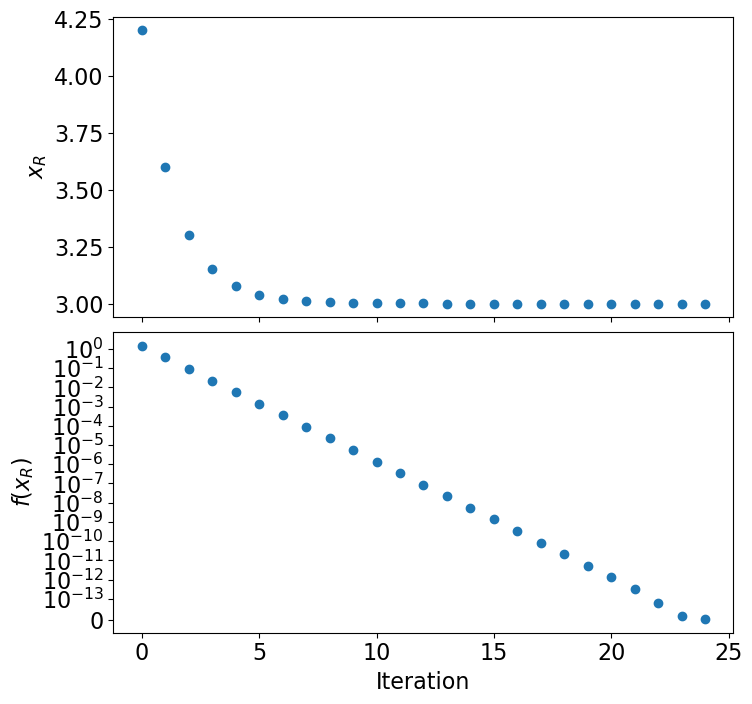

In [11]:
def newtonRoot(f,x0,fp=None,eps=1e-8,tol=1e-14,maxits=100):
    xr = [x0]
    err= [f(x0)]
    itr= 1
    while itr<maxits:
        
        # take estimate of the root from the previous iteration:
        xi = xr[itr-1]
        
        # compute f'(xi):
        if isinstance(fp,type(None)):
            fprime = (f(xi + eps) - f(xi - eps))/2/eps
        else:
            fprime = fp(xi)
            
        # compute new estimate of root:
        xr.append(xi - f(xi)/fprime)
        
        # check for convergence to root:
        err.append(f(xr[-1]))
        if abs(err[-1])<tol:
            print(f'root found at {xr[-1]}')
            break
            
        # advance iteration:
        itr+= 1
    return np.array(xr),np.array(err)

# compute roots for a factored polynomial:
rts,err = newtonRoot(f=lambda x: (x-3.)**2,x0=4.2,fp=lambda x: 2*x - 2*3)
itr = len(rts)

f,ax = plt.subplots(2,1,figsize=(8,8),sharex=True)
ax[0].plot(np.arange(itr),rts,'o')
ax[1].plot(np.arange(itr),abs(err),'o')
ax[1].set_xlabel('Iteration')
ax[0].set_ylabel('$x_R$')
ax[1].set_ylabel('$f(x_R)$')
ax[1].set_yscale('symlog',linthresh=1e-13)
plt.subplots_adjust(hspace=0.05)

# compute roots for a factored polynomial:
rts,err = newtonRoot(f=lambda x: (x-4)*(x-5),x0=4.2)
rts,err = newtonRoot(f=lambda x: (x-4)*(x-5),x0=6.)

## Exercise 6

Text(0, 0.5, 'Error')

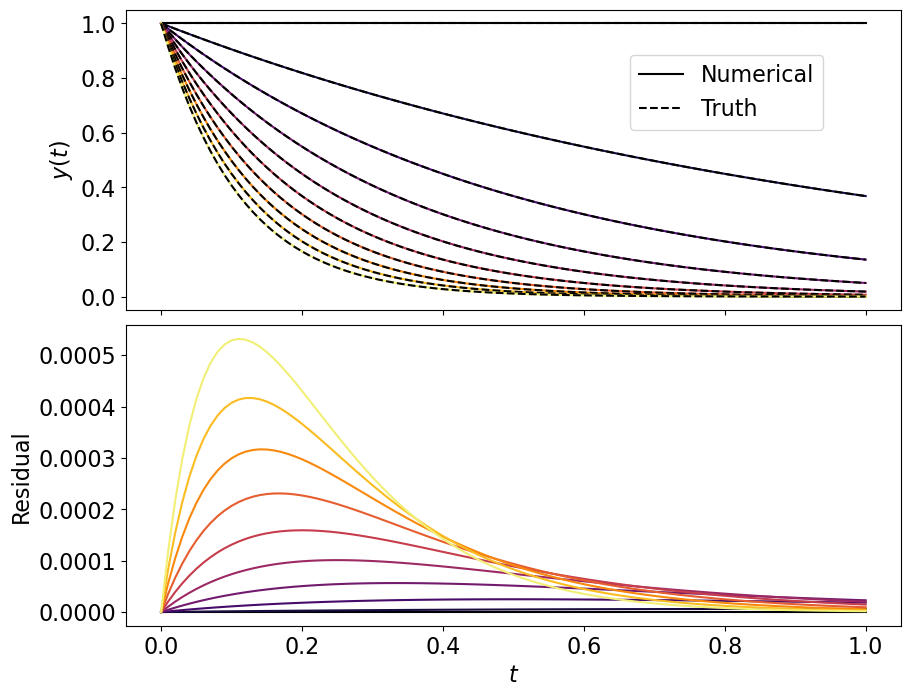

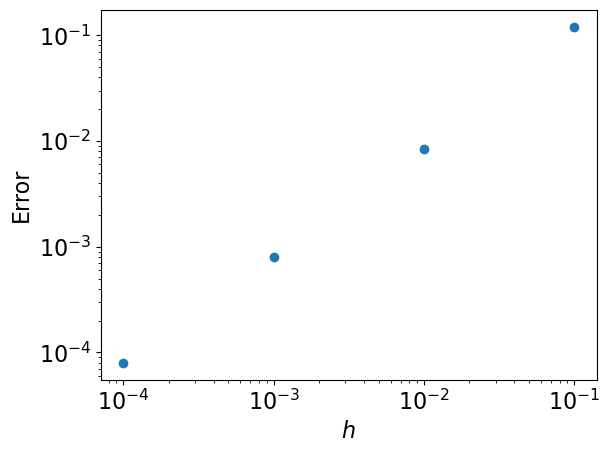

In [12]:
def integrateIVP2(rhf,tlim,y0,h,**kwargs):

    # define function to compute y_i+1 from y_i:
    def iterate(ti,yi):
        Fi = rhf(ti,yi,**kwargs)
        return yi + h*rhf(ti + 0.5*h, yi + 0.5*h*Fi,**kwargs)

    # set initial conditions at t=t0:
    t0,tf = tlim
    tt = np.linspace(t0,tf,int((tf-t0)/h)+1)
    yy = [y0]

    # integrate forward in time to t=tf:
    for i,t in enumerate(tt[1:]):
        yy.append(iterate(tt[i],yy[i]))
        
    return tt,np.array(yy)

# RHS function:
def F(t,y,a=5):
    return -a*y

# compute and plot solutions & residuals:
cols = plt.cm.inferno(np.linspace(0,.95,10))
f,ax = plt.subplots(2,1,figsize=(10,8),sharex=True)
for i,aa in enumerate(np.arange(10)):
    tt,yy = integrateIVP2(rhf=F,tlim=(0,1.),y0=1,h=0.01,a=aa)
    ax[0].plot(tt,yy,label='Numerical' if i==0 else '__nolegend__',color=cols[i])
    ax[0].plot(tt,np.exp(-aa*tt),'--',label='Truth' if i==0 else '__nolegend__',color='k')    
    ax[1].plot(tt,yy-np.exp(-aa*tt),color=cols[i])
ax[1].set_xlabel('$t$')
ax[0].set_ylabel('$y(t)$')
ax[1].set_ylabel('Residual')
ax[0].legend(loc=(0.65,0.6))
plt.subplots_adjust(hspace=0.05)

# compute and plot cumulative errors:
errs = []
Nvals= [10,100,1000,10000]
hvals= [1./N for N in Nvals]
for h in hvals:    
    tt,yy = integrateIVP2(rhf=F,tlim=(0,1.),y0=1,h=h,a=5)
    errs.append(np.sum(abs(yy - np.exp(-5*tt))))
    
plt.figure()
plt.loglog(hvals,errs,'o')
plt.xlabel('$h$')
plt.ylabel('Error')

## Exercise 7

iteration 0:
err= 0.7521769155632596
[[ 0.0023441   1.5704681 ]
 [ 0.25026141 -0.0676683 ]]
dv= [ 2.99467623 -0.00594874]
iteration 1:
err= 0.02877043180652794
[[-0.00692458  6.29975374]
 [ 0.25060072 -0.29532973]]
dv= [0.00251112 0.00446046]
iteration 2:
err= 0.00022010593680477086
[[ 1.25804922e-04  6.29386712e+00]
 [ 2.50326160e-01 -2.82833612e-01]]
dv= [-8.68687844e-04  4.19652668e-07]
iteration 3:
err= 6.76362188478663e-10
[[ 1.26204602e-04  6.29249374e+00]
 [ 2.50325916e-01 -2.82781348e-01]]
dv= [4.87897630e-10 9.22119324e-11]
iteration 4:
err= 2.6645352591003757e-15
solution converged after 4 iterations


Text(0.5, 0.98, '$k=4.00$')

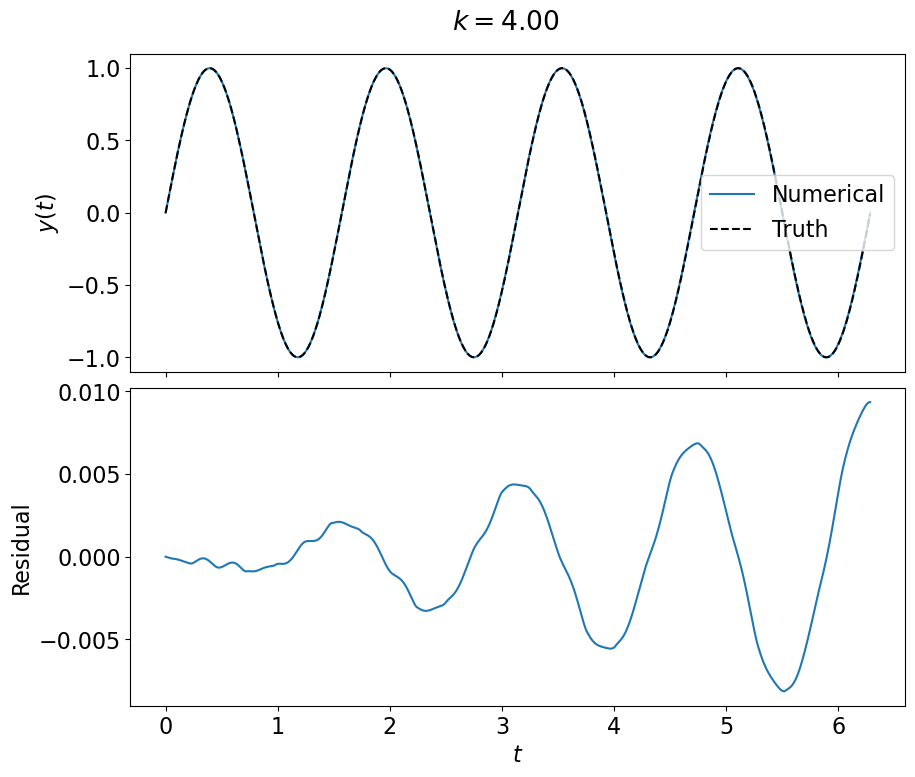

In [15]:
from scipy.integrate import solve_ivp
from scipy.linalg import solve

plt.rcParams.update({'font.size':16})

def shootNR(iterfun,v0,maxits=100,eps=1e-8,tol=1e-12,alf=1):
    '''
        uses a shooting method with Newton iteration to solve BVPs
        
            iterfun:    function that implements a single integration given 
                        guesses at initial conditions/unspecified parameters.
                        assumed to take array of parameters varied at first 
                        integration point, and return both (i) the integrated 
                        solution and (ii) an array of deviations from the desired 
                        BCs at final integration point
            ic0:        array-like. initial guess at parameters varied 
    '''
    # array of conditions varied:
    v = np.array(v0)
    Nv= len(v)
    
    # iterate
    itr = 0
    conv= False
    while itr<maxits:
        print(f'iteration {itr}:')
        
        # primary integration for this iteration
        sol,f = iterfun(v)
        
        # check for convergence:
        err = np.sum(abs(f))
        print('err=',err)        
        if err<tol:
            print(f'solution converged after {itr} iterations')
            conv = True
            break
        
        # compute Jacobian by perturbing each parameter varied:
        J = np.zeros([Nv,Nv])
        for j in range(Nv):
            dl = np.zeros([Nv])
            dl[j] = 1.
            df = iterfun(v + eps*dl)[1] - iterfun(v - eps*dl)[1]
            J[:,j] = df/2/eps
            
        # calculate correction to parameter vector:
        print(J)
        dv = solve(J,-f)
        v += dv*alf
        print('dv=',dv)
        itr+= 1 
        
    # warning for unconverged solutions
    if conv==False:
        print(f'solution did not converge after {itr} iterations')
    return sol


# define grid-points for evaluation and exact answer:
x = np.linspace(0,2*np.pi,1000)
ep= 0.4
def iterfun(v):
    sol = solve_ivp(fun=lambda x,y: [y[1],-y[2]*y[2]*y[0],0],
                    y0=[0,*v],t_span=[0,2*np.pi],t_eval=x)
    f = np.array([sol.y[0][-1],np.amax(sol.y[0])-1.])
    return sol,f 

sol = shootNR(iterfun,v0=[1.,4])
k = sol.y[2][0]
ans = np.sin(k*sol.t)

# plot results:
f,ax = plt.subplots(2,1,figsize=(10,8),sharex=True)
ax[0].plot(sol.t,sol.y[0]/np.amax(sol.y[0]),label='Numerical')
ax[0].plot(x,ans,'k--',label='Truth')
ax[1].plot(x,sol.y[0]-ans)
ax[1].set_xlabel('$t$')
ax[0].set_ylabel('$y(t)$')
ax[1].set_ylabel('Residual')
ax[0].legend()
plt.subplots_adjust(hspace=0.05,top=0.925)
plt.suptitle(f'$k={k:.2f}$')

## Spectral upgrade 

(0.9999999999999589-0j)
(1.999999999999965-0j)
(2.9999999999999916-0j)
(4.000000000000008-0j)
(4.9999999999999885-0j)


/home/janosz/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


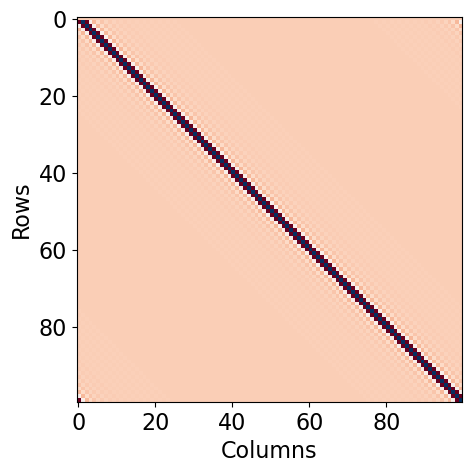

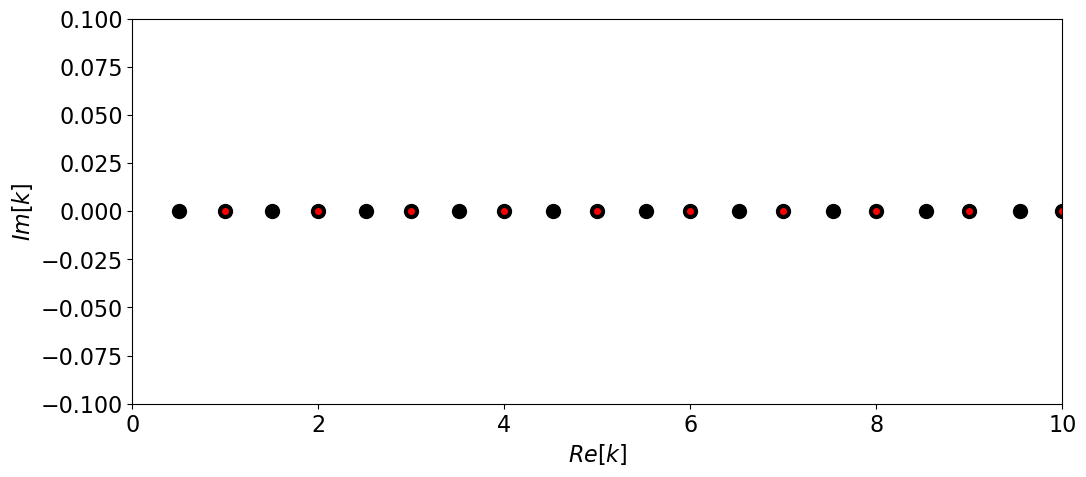

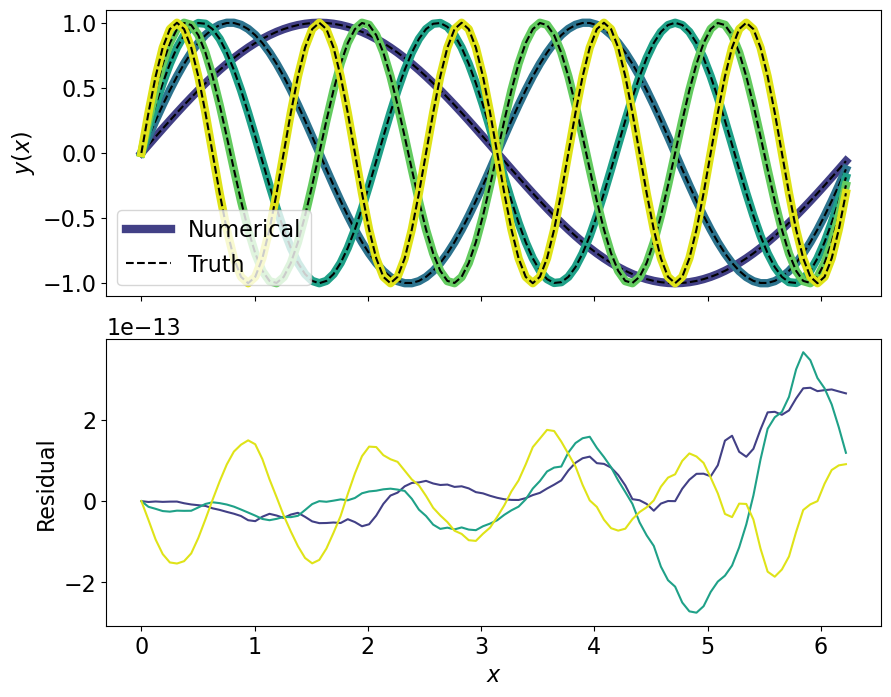

In [16]:
N = 50
x = np.arange(0,2*N)*np.pi/N

# make matrix:
D2= np.zeros([2*N,2*N])
for i in range(2*N):
    for j in range(2*N):
        D2[i,j] = -(1. + 2.*N**2)/6. if i==j else 0.5*(-1.)**(i-j+1)/(np.sin(.5*(x[i]-x[j])))**2
B = np.eye(2*N)    
    
# impose BC's (just one, since end-point does not include 2*pi):
D2[0,:] = 0
D2[0,0] = 1.
B[0,:]  = 0

# visualize the matrix:
f,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(D2,cmap='RdBu_r')
ax.set_ylabel('Rows')
ax.set_xlabel('Columns')

from scipy.linalg import eig

w,y = eig(D2)
k = np.sqrt(-w)

# plot eigenfrequencies:
f,ax = plt.subplots(1,1,figsize=(12,5))
ax.plot(k.real,k.imag,'ko',ms=10)
ax.plot(np.arange(1,20),[0 for i in range(1,20)],'ro',ms=4)
ax.set_ylim([-.1,.1])
ax.set_xlim([0,10])
ax.set_xlabel('$Re[k]$')
ax.set_ylabel('$Im[k]$')

# plot solutions:
f,ax = plt.subplots(2,1,figsize=(10,8),sharex=True)
cols = plt.cm.viridis(np.linspace(0,.95,6))
for kk in range(1,6):
    idx = np.argmin(abs(k - kk))
    print(k[idx])
    soly= y[:,idx]*np.sign(y[1,idx])
    soly= soly/np.amax(abs(soly))
    ans = np.sin(k[idx]*x)
    ax[0].plot(x,soly,label='Numerical' if kk==1 else '__nolegend__',color=cols[kk],lw=6)
    ax[0].plot(x,ans,'k--',label='Truth' if kk==1 else '__nolegend__')
    if kk%2: ax[1].plot(x,soly-ans,color=cols[kk])

ax[1].set_xlabel('$x$')
ax[0].set_ylabel('$y(x)$')
ax[1].set_ylabel('Residual')
ax[0].legend()
plt.subplots_adjust(hspace=0.15)